# Такси

## 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
from sklearn.linear_model import LinearRegression,  LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
!pip install catboost
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import RandomizedSearchCV
#!pip install imblearn
#from imblearn.over_sampling import SMOTE
from multiprocessing import cpu_count
cpu_count()

12

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<AxesSubplot:xlabel='datetime'>

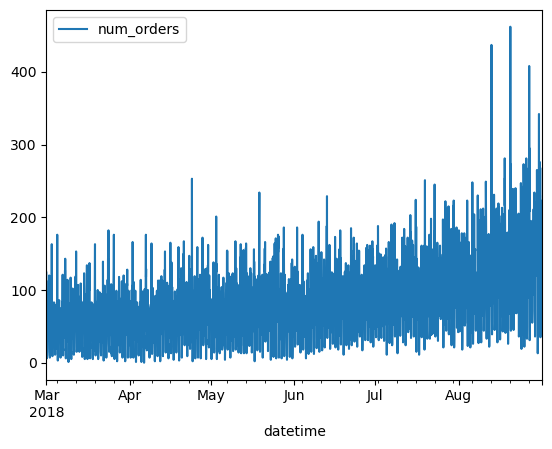

In [5]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()
data.plot()

In [6]:
data.index.is_monotonic

True

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='datetime'>

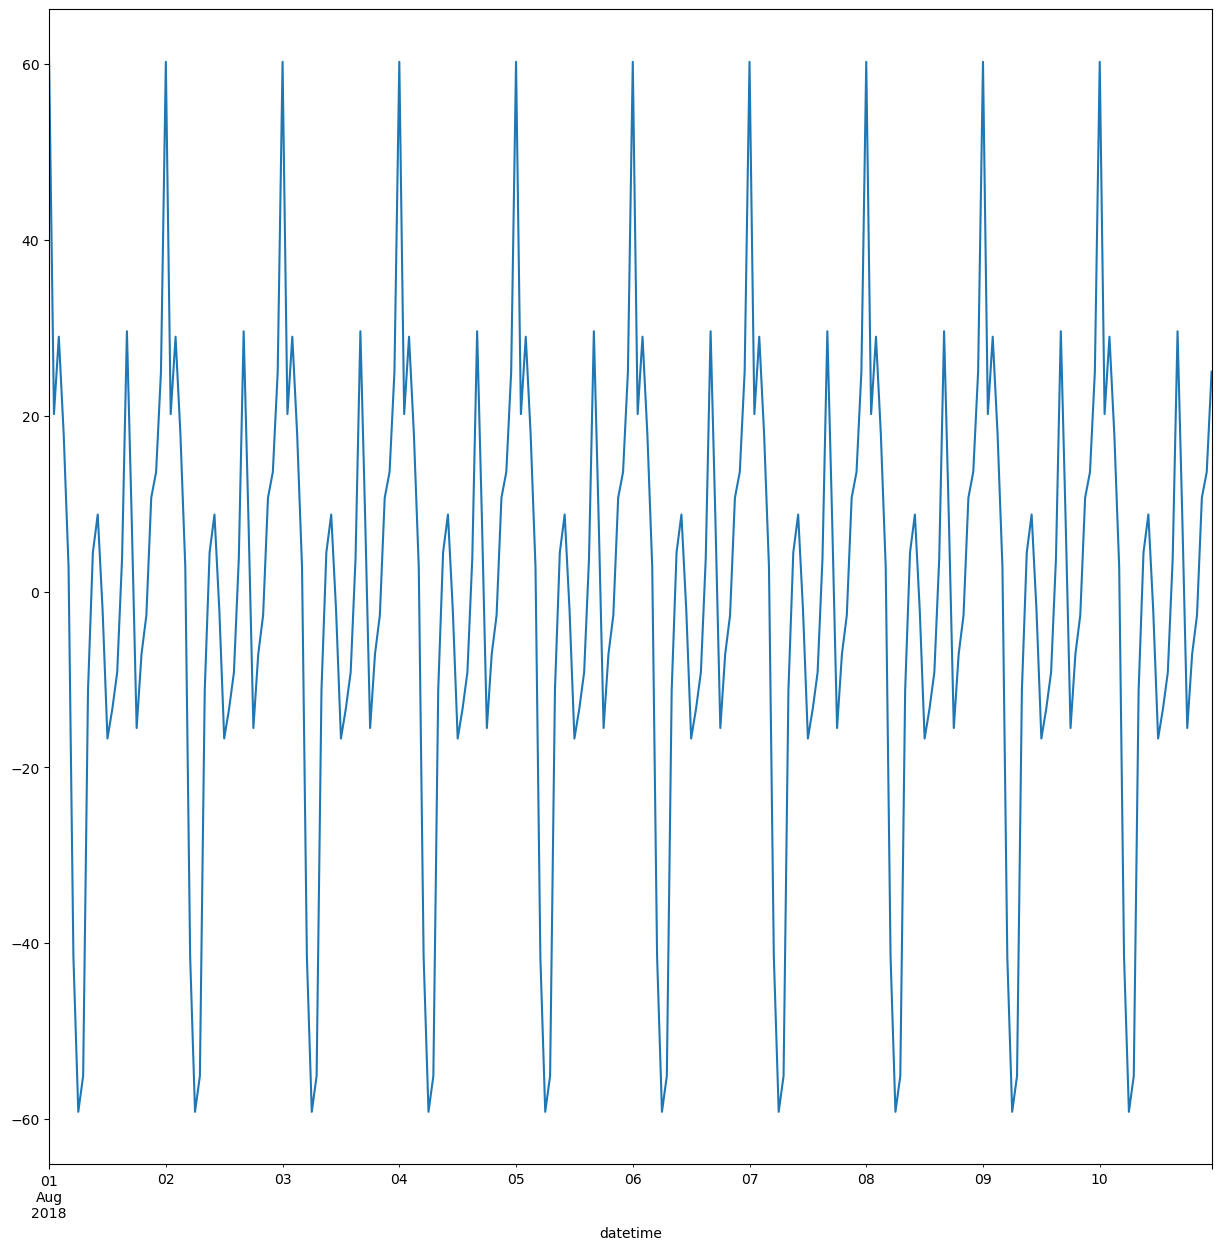

In [8]:
decomposed = seasonal_decompose(data)

decomposed.seasonal['2018-08-01' : '2018-08-10'].plot(ax=plt.gca(), figsize = (15,15))

<AxesSubplot:xlabel='datetime'>

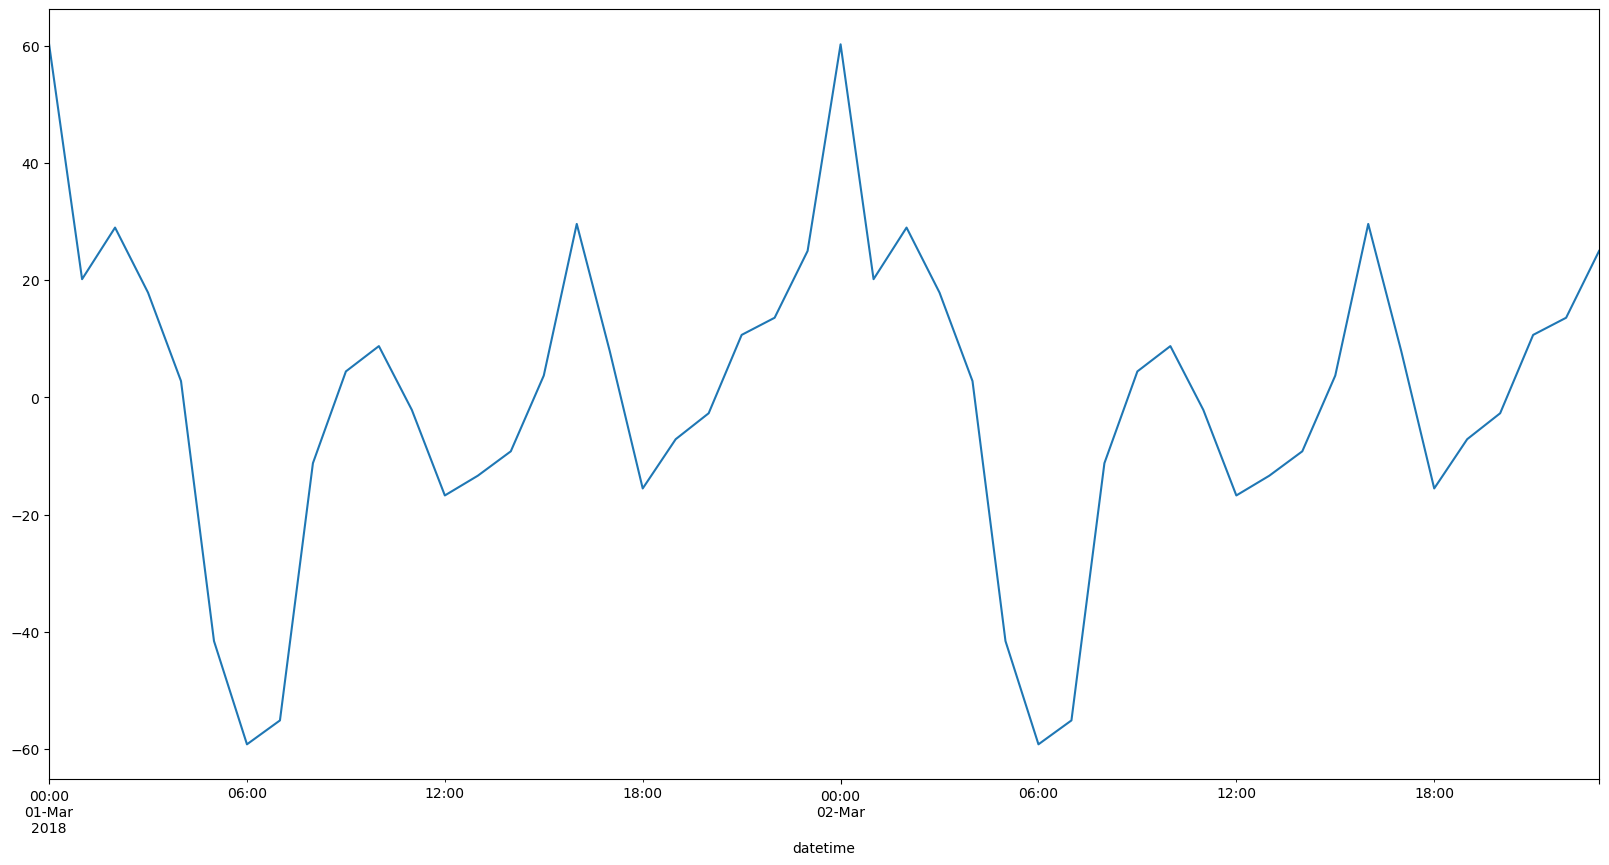

In [9]:
decomposed = seasonal_decompose(data)

decomposed.seasonal['2018-03-01' : '2018-03-02'].plot(ax=plt.gca(), figsize = (20,10))

Количество заказов зависит от времени суток и посторяется день ото дня.

<AxesSubplot:xlabel='datetime'>

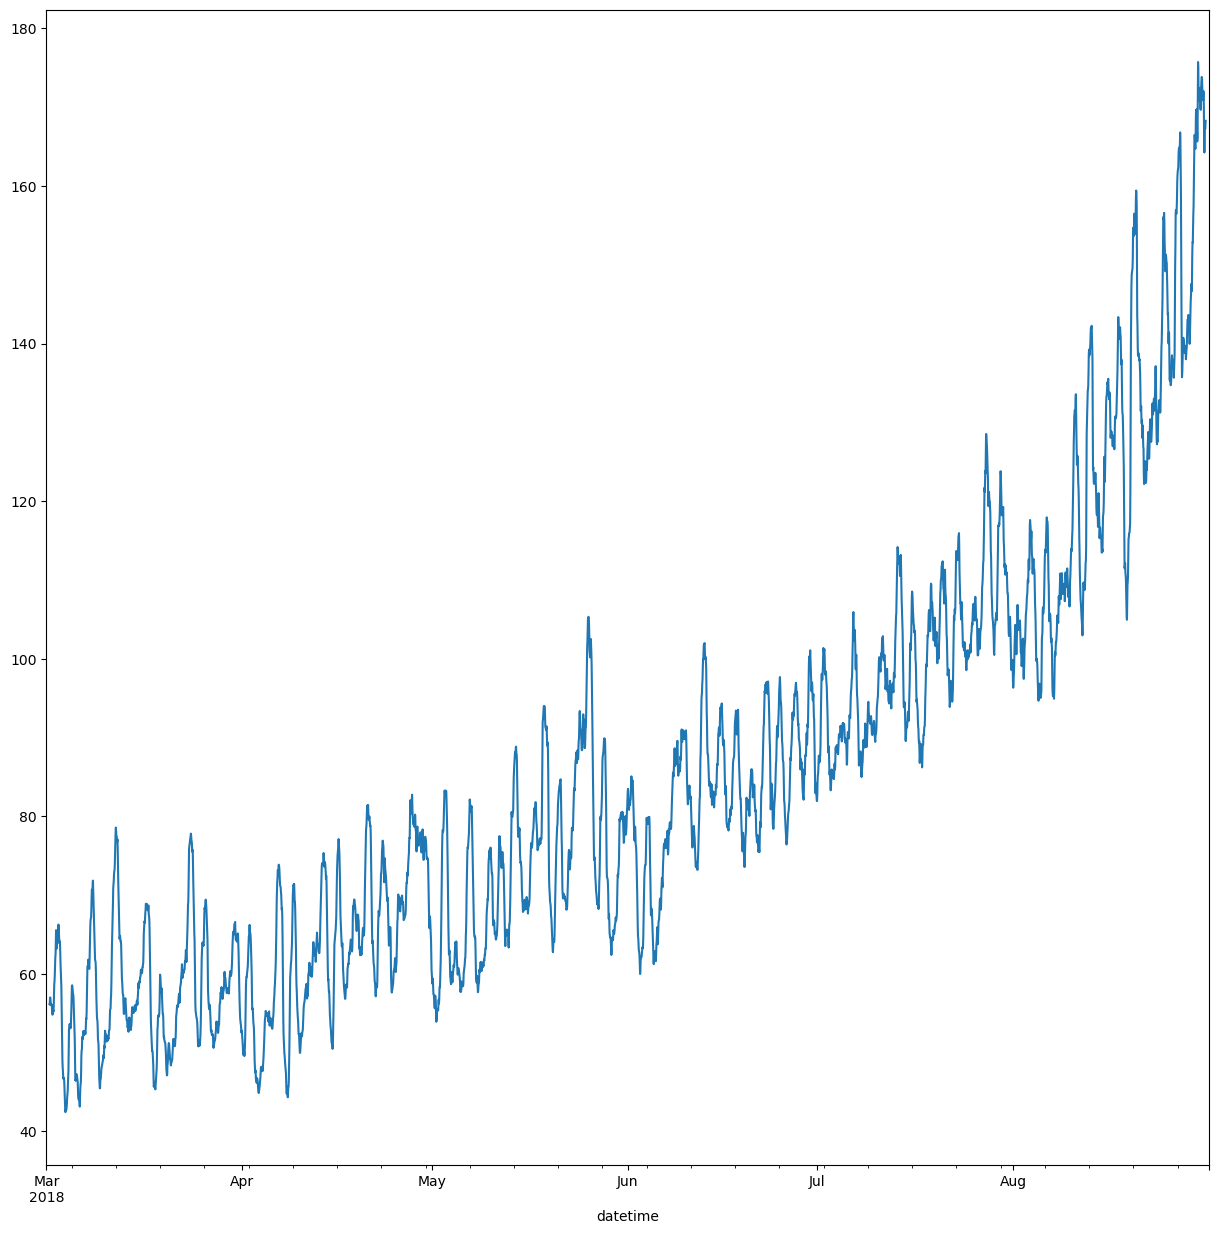

In [10]:
decomposed.trend.plot(ax=plt.gca(), figsize = (15,15))

Есть тренд на увеличение количества заказов

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


make_features(data, 6, 10)

train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

test_features=test.drop(['num_orders'], axis=1)
test_target = test['num_orders']
train_features=train.drop(['num_orders'], axis=1)
train_target = train['num_orders']

Согласна с вышесказанным

## 2. Обучение моделей и подбор гиперпараметров

### Модель CatBoostRegressor:

In [12]:
def rmse(actual, predict):
    score = math.sqrt(mean_squared_error(actual, predict))
    return score
rmse_score = make_scorer(rmse, greater_is_better = False)

In [13]:
space={'depth'         : [4,5,6,7,8,9, 10],
       'learning_rate' : [0.01,0.02,0.03,0.04,1],
       'iterations'    : [10, 20,30,40,50,60,70,80,90, 100]
                 }

In [14]:
%%time
CBR = CatBoostRegressor()
CBR_random = RandomizedSearchCV(CBR, space, n_iter=500, scoring=rmse_score, n_jobs=-1, cv=3)
model_random = CBR_random.fit(train_features, train_target)

print('Best hyperparameters are: '+str(model_random.best_params_))
print('Best score is: '+str(model_random.best_score_))

C:\Users\1382697\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 350 is smaller than n_iter=500. Running 350 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0:	learn: 29.6731326	total: 147ms	remaining: 2.79s
1:	learn: 27.0656920	total: 148ms	remaining: 1.33s
2:	learn: 26.3545837	total: 149ms	remaining: 847ms
3:	learn: 26.1532254	total: 151ms	remaining: 603ms
4:	learn: 24.9711313	total: 152ms	remaining: 456ms
5:	learn: 24.6406486	total: 153ms	remaining: 358ms
6:	learn: 24.3889224	total: 155ms	remaining: 287ms
7:	learn: 24.2206410	total: 156ms	remaining: 234ms
8:	learn: 24.1489759	total: 157ms	remaining: 192ms
9:	learn: 23.7840930	total: 158ms	remaining: 158ms
10:	learn: 23.4392937	total: 160ms	remaining: 131ms
11:	learn: 23.2123584	total: 161ms	remaining: 107ms
12:	learn: 22.9782815	total: 162ms	remaining: 87.3ms
13:	learn: 22.6064379	total: 163ms	remaining: 70ms
14:	learn: 22.4442161	total: 165ms	remaining: 54.9ms
15:	learn: 22.2714192	total: 166ms	remaining: 41.5ms
16:	learn: 21.9567176	total: 167ms	remaining: 29.5ms
17:	learn: 21.8060479	total: 168ms	remaining: 18.7ms
18:	learn: 21.6426079	total: 170ms	remaining: 8.92ms
19:	learn: 21.605

In [15]:
%%time
model = CatBoostRegressor(iterations=20, 
                          depth=4, 
                          learning_rate=1, 
                          loss_function='RMSE') 

model.fit(train_features, train_target, verbose=10)


0:	learn: 29.6731326	total: 1.33ms	remaining: 25.3ms
10:	learn: 23.4392937	total: 14.3ms	remaining: 11.7ms
19:	learn: 21.6055813	total: 25.6ms	remaining: 0us
Wall time: 41.7 ms


In [16]:
%%time
prediction = model.predict(train_features)
print('RMSE Модели CatBoostRegressor:', math.sqrt(mean_squared_error(train_target, prediction)))

RMSE Модели CatBoostRegressor: 21.605581349355013
Wall time: 0 ns


### Модель LightGBM:

In [17]:
space={'max_depth':list(np.arange(10, 100, step=10)) + [None],
       'n_estimators':np.arange(10, 500, step=50),
       'num_leaves':list(np.arange(10, 150, step=10)) + [None]
         }

In [18]:
%%time
LGBM = LGBMRegressor()
LGBM_random = RandomizedSearchCV(LGBM, space, n_iter=500, scoring=rmse_score, n_jobs=-1, cv=3)
model_random = LGBM_random.fit(train_features, train_target)

print('Best hyperparameters are: '+str(model_random.best_params_))
print('Best score is: '+str(model_random.best_score_))

Best hyperparameters are: {'num_leaves': 20, 'n_estimators': 110, 'max_depth': 50}
Best score is: -25.754952154789837
Wall time: 1min 57s


In [19]:
%%time
model = LGBMRegressor(num_leaves=20,  n_estimators=110, max_depth=60)
model.fit(train_features, train_target)


Wall time: 244 ms


LGBMRegressor(max_depth=60, n_estimators=110, num_leaves=20)

In [20]:
%%time
prediction = model.predict(train_features)
print('RMSE Модели LightGBM:', math.sqrt(mean_squared_error(train_target, prediction)))

RMSE Модели LightGBM: 17.223792002707988
Wall time: 16.9 ms


Выводы:
Модель LightGBM показала наилучший результат 17.22

## 3. Тестирование модели

In [21]:
%%time
model = LGBMRegressor(num_leaves=20,  n_estimators=110, max_depth=60)
model.fit(train_features, train_target)


Wall time: 231 ms


LGBMRegressor(max_depth=60, n_estimators=110, num_leaves=20)

In [22]:
%%time
prediction_test = model.predict(test_features)
print('RMSE Модели LightGBM:', math.sqrt(mean_squared_error(test_target, prediction_test)))

RMSE Модели LightGBM: 45.668421002557
Wall time: 4.99 ms


Модель прошла проверку, RMSE 46 - это меньше 48(соответсвует условию).

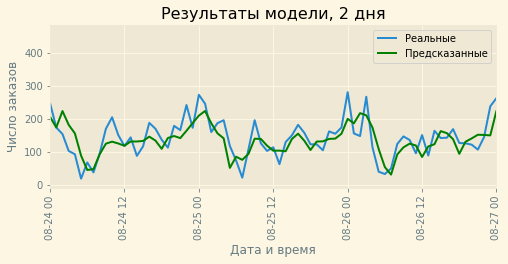

In [23]:
test['pred']=prediction_test

In [24]:
test_pl = test['2018-08-15' : '2018-08-17']
test_pl.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2018-08-15 00:00:00 to 2018-08-17 23:00:00
Freq: H
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    72 non-null     int64  
 1   hour          72 non-null     int64  
 2   dayofweek     72 non-null     int64  
 3   lag_1         72 non-null     float64
 4   lag_2         72 non-null     float64
 5   lag_3         72 non-null     float64
 6   lag_4         72 non-null     float64
 7   lag_5         72 non-null     float64
 8   lag_6         72 non-null     float64
 9   rolling_mean  72 non-null     float64
 10  pred          72 non-null     float64
dtypes: float64(8), int64(3)
memory usage: 6.8 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 442 entries, 2018-08-13 14:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   n

Text(0.5, 1.0, 'Результаты модели, 2 дня')

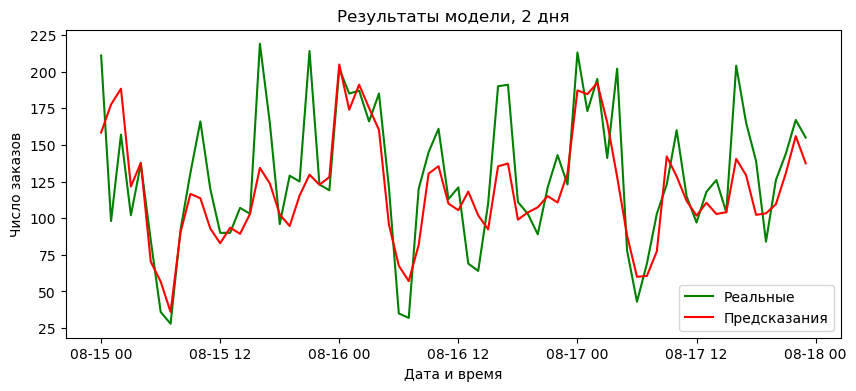

In [25]:
plt.figure(figsize=(10,4))
plt.plot(test_pl['num_orders'],color='green', label='Реальные')
plt.plot(test_pl['pred'],color='red', label ='Предсказания')
plt.legend()
plt.xlabel('Дата и время')
plt.ylabel('Число заказов')
plt.title('Результаты модели, 2 дня')